### GFMS:
http://flood.umd.edu  
http://eagle2.umd.edu/flood/download/  subfolder: [year][yearmm]  
Flood_byStor_yyyymmddhh.bin  Flood intensity (in depth) above threshold mm  

In [1]:
from datetime import date
import requests, wget
import os, sys,json
import numpy as np
import math

In [13]:
baseurl = "http://eagle2.umd.edu/flood/download/"
# find the latest data set
cur_year, cur_month = map(str,[date.today().year,date.today().month])
cur_month = cur_month.zfill(2)
dataurl = baseurl + cur_year + "/" + cur_year + cur_month 
print(dataurl)

http://eagle2.umd.edu/flood/download/2020/202001


In [14]:
response = requests.get(dataurl)
raw_text = response.text.split()
data_list = [x.split("'")[1] for x in raw_text if "href" in x]
latest_data = data_list[-2]
latest_data_url = dataurl + "/" + latest_data
print(latest_data_url)

http://eagle2.umd.edu/flood/download/2020/202001/Flood_byStor_2020013118.bin


In [15]:
if not os.path.exists(latest_data):
    wget.download(latest_data_url)

In [5]:
# generate header file
hdr_header = """NCOLS 2458
NROWS 800
XLLCORNER -127.25
YLLCORNER -50
CELLSIZE 0.125
PIXELTYPE FLOAT
BYTEORDER LSBFIRST
NODATA_VALUE -9999
"""
header_file = latest_data.replace(".bin",".hdr")
with open(header_file,"w") as f:
    f.write(hdr_header)

In [6]:
vrt_template="""<VRTDataset rasterXSize="2458" rasterYSize="800">
  <SRS>GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]</SRS>
  <GeoTransform> -1.2725000000000000e+02,  1.2500000000000000e-01,  0.0000000000000000e+00,  5.0000000000000000e+01,  0.0000000000000000e+00, -1.2500000000000000e-01</GeoTransform>
  <VRTRasterBand dataType="Float32" band="1">
    <Metadata>
      <MDI key="STATISTICS_APPROXIMATE">YES</MDI>
      <MDI key="STATISTICS_MAXIMUM">1345.408203125</MDI>
      <MDI key="STATISTICS_MEAN">26.161176808621</MDI>
      <MDI key="STATISTICS_MINIMUM">1.1765951057896e-07</MDI>
      <MDI key="STATISTICS_STDDEV">120.73468295071</MDI>
      <MDI key="STATISTICS_VALID_PERCENT">1.117</MDI>
    </Metadata>
    <NoDataValue>-9999</NoDataValue>
    <ComplexSource>
      <SourceFilename relativeToVRT="1">{}</SourceFilename>
      <SourceBand>1</SourceBand>
      <SourceProperties RasterXSize="2458" RasterYSize="800" DataType="Float32" BlockXSize="2458" BlockYSize="1" />
      <SrcRect xOff="0" yOff="0" xSize="2458" ySize="800" />
      <DstRect xOff="0" yOff="0" xSize="2458" ySize="800" />
      <NODATA>-9999</NODATA>
    </ComplexSource>
  </VRTRasterBand>
</VRTDataset>"""

In [7]:
# generate VRT file
vrt_file = latest_data.replace(".bin",".vrt")
with open(vrt_file,"w") as f:
    f.write(vrt_template.format(latest_data))

check the vrt file with gdalinfo
!gdalinfo {vrt_file}

Driver: VRT/Virtual Raster
Files: Flood_byStor_2020011318.vrt
       Flood_byStor_2020011318.bin
Size is 2458, 800
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
Origin = (-127.250000000000000,50.000000000000000)
Pixel Size = (0.125000000000000,-0.125000000000000)
Corner Coordinates:
Upper Left  (-127.2500000,  50.0000000) (127d15' 0.00"W, 50d 0' 0.00"N)
Lower Left  (-127.2500000, -50.0000000) (127d15' 0.00"W, 50d 0' 0.00"S)
Upper Right ( 180.0000000,  50.0000000) (180d 0' 0.00"E, 50d 0' 0.00"N)
Lower Right ( 180.0000000, -50.0000000) (180d 0' 0.00"E, 50d 0' 0.00"S)
Center      (  26.3750000,   0.0000000) ( 26d22'30.00"E,  0d 0' 0.01"N)
Band 1 Block=128x128 Type=Float32, ColorInterp=Undefined
  Min=0.000 Max=1345.408 
  Minimum=0.000, Maximum=1345.408, Mean=26.161, StdDev=120.735
  NoData Value=-9999
  Metadata:
    STATISTICS_APPROXIMATE=YES
    STATISTICS_MAXIMUM=1345.408203125
    STATISTICS_MEAN=26.161176808621
    STATISTICS_MINIMUM=1.1765951057896e-07
    STATISTICS_STDDEV=120.73468295071
    STATISTICS_VALID_PERCENT=1.117

In [2]:
###The usual python imports for the notebook
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

In [10]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 18})

gdal.UseExceptions()

#Utility function to load data
def loadData(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    #Data array
    data = ds.GetRasterBand(band).ReadAsArray()
    #Map extent
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
            trans[3] + ysize*trans[5], trans[3]]
    
    ds = None
    return data, extent

NameError: name 'latest_data' is not defined

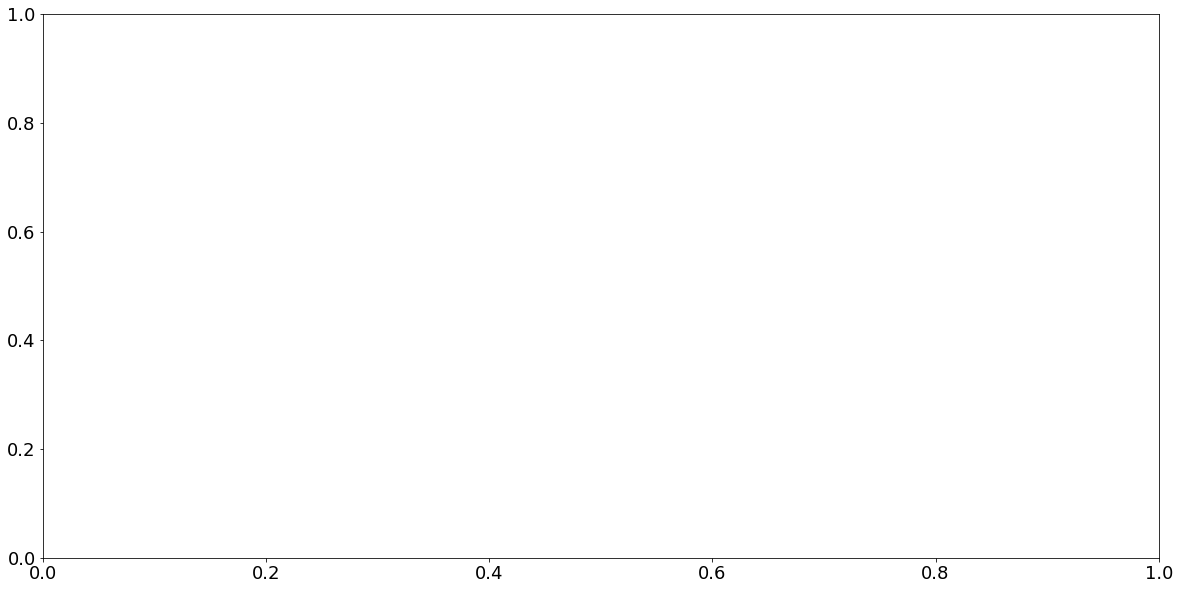

In [11]:
# for testing purpose
vrt_file = 'Flood_byStor_2020011718.vrt'

vrt_nodata = -9999.0
vrt_data, vrt_ext = loadData(vrt_file)
vrt_data[vrt_data == vrt_nodata] = np.nan
fig,ax = plt.subplots()
ax.set(xlabel='Longitude',ylabel='Latitude',title = latest_data)
img_plot = plt.imshow(vrt_data, extent=vrt_ext,cmap="jet",vmin=0.01,vmax=200.0)
ax.grid(True)
#ax.set_aspect(1.5)
plt.show()

### Watersheds
https://www.wri.org/resources/data-sets/aqueduct-global-maps-30-data

In [5]:
watersheds_gdb = 'WRIWatersheds.gdb'
# ogrinfo WRIWatersheds.gdb/
#1: aqid_watersheds_wrisk (Multi Polygon)
from osgeo import ogr
driver = ogr.GetDriverByName('OpenFileGDB')
ds = driver.Open(watersheds_gdb,0)
layer = ds.GetLayer()
featureCount = layer.GetFeatureCount() 
print(layer.GetName(),featureCount)

aqid_watersheds_wrisk 3401


In [6]:
# use geopandas
import geopandas
watersheds = geopandas.read_file(watersheds_gdb)
watersheds.head()

,aqid,FIRST_aqid,FIRST_gid_0,FIRST_name_0,FIRST_name_1,SUM_area_km2,MEAN_rfr_score,MEAN_cfr_score,Shape_Length,Shape_Area,geometry
0,-9999,-9999,EGY,Egypt,As Suways,855919.290693,2.116889,1.17131,14329.046938,163.155967,"MULTIPOLYGON (((-67.247 -55.934, -67.245 -55.9..."
1,1,1,GRL,Greenland,Northeast Greenland National Park,76.115674,0.000000,0.00000,1.473418,0.052678,"MULTIPOLYGON (((-38.903 83.291, -39.031 83.286..."
2,2,2,GRL,Greenland,Northeast Greenland National Park,209.303431,0.000000,0.00000,4.145705,0.143175,"MULTIPOLYGON (((-40.499 83.359, -40.454 83.357..."
3,3,3,GRL,Greenland,Northeast Greenland National Park,15.278516,0.000000,0.00000,0.915296,0.010402,"MULTIPOLYGON (((-41.233 83.306, -41.253 83.285..."
4,4,4,GRL,Greenland,Northeast Greenland National Park,15.816344,0.000000,0.00000,0.921070,0.010673,"MULTIPOLYGON (((-42.184 83.270, -42.149 83.269..."


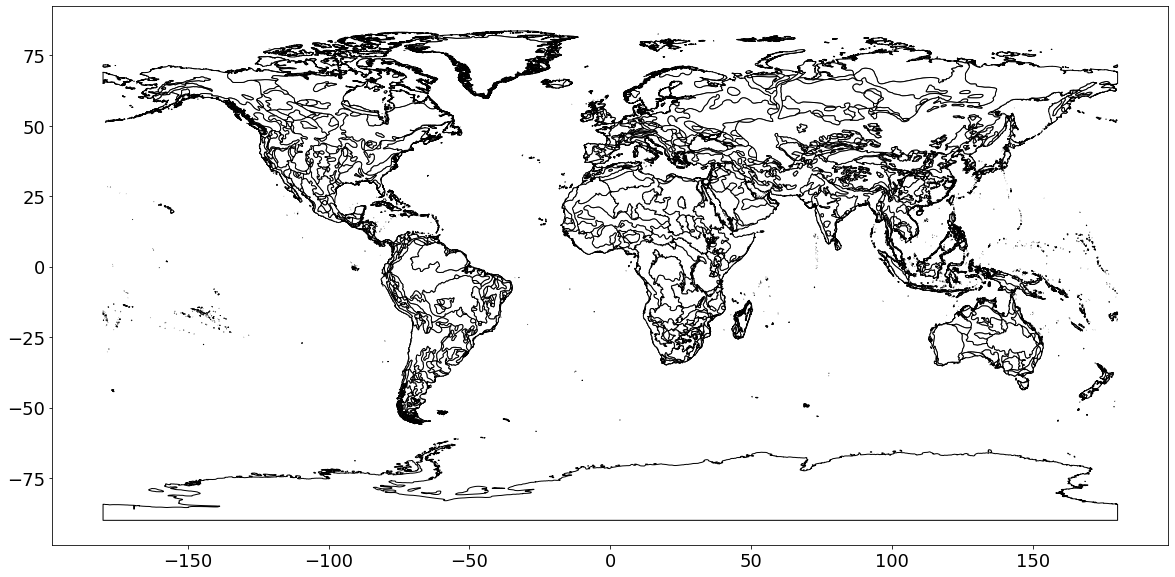

In [13]:
watersheds.plot(color='white', edgecolor='black')

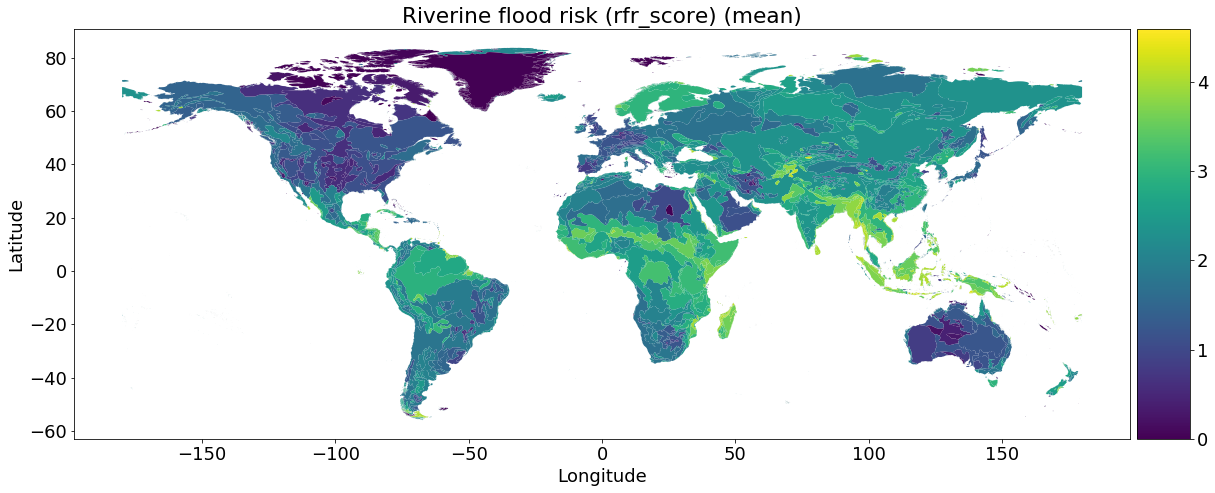

In [14]:
#MEAN_rfr_score Riverine flood risk (rfr_score) (mean)
#MEAN_cfr_score Coastal flood risk (cfr_score) (mean)
watersheds = watersheds[watersheds.MEAN_rfr_score.notnull()]
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set(xlabel='Longitude',ylabel='Latitude',title = "Riverine flood risk (rfr_score) (mean)")
watersheds.plot(column='MEAN_rfr_score', ax=ax, legend=True, cax=cax)

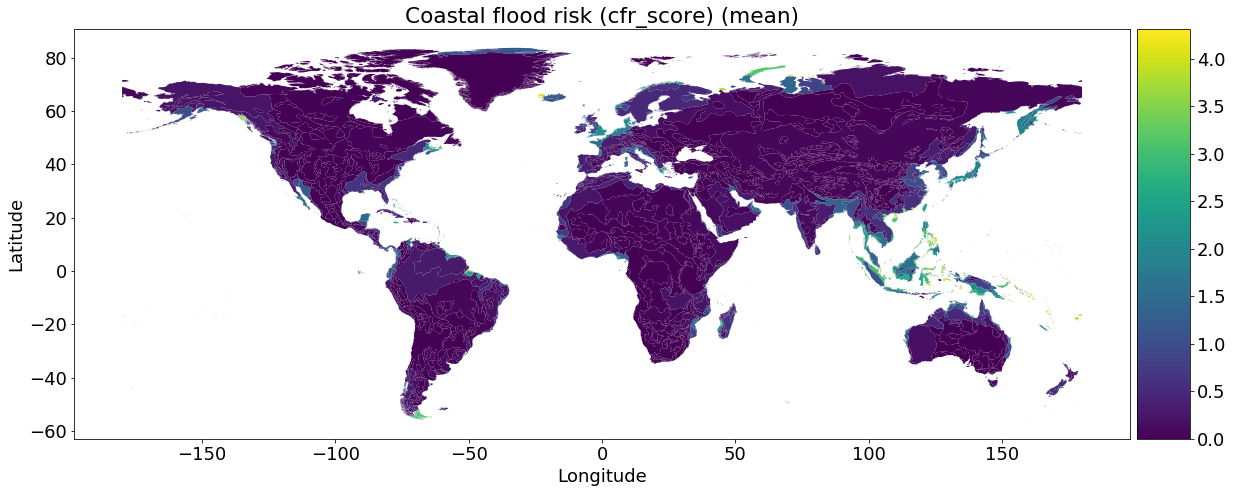

In [15]:
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set(xlabel='Longitude',ylabel='Latitude',title = "Coastal flood risk (cfr_score) (mean)")
watersheds.plot(column='MEAN_cfr_score', ax=ax, legend=True, cax=cax)

### Extract GFMS data inside a watershed

In [7]:
# set index by aqid
watersheds.set_index("aqid",inplace=True)

In [9]:
# pick a testing case
test_aqid = 2538
watersheds.loc[test_aqid]


FIRST_aqid                                                     2538
FIRST_gid_0                                                     IDN
FIRST_name_0                                              Indonesia
FIRST_name_1                                            Jawa Tengah
SUM_area_km2                                                60674.7
MEAN_rfr_score                                               3.5097
MEAN_cfr_score                                              1.45883
Shape_Length                                                 21.191
Shape_Area                                                  4.93845
geometry          (POLYGON ((106.598295292 -6.516266177999967, 1...
Name: 2538, dtype: object

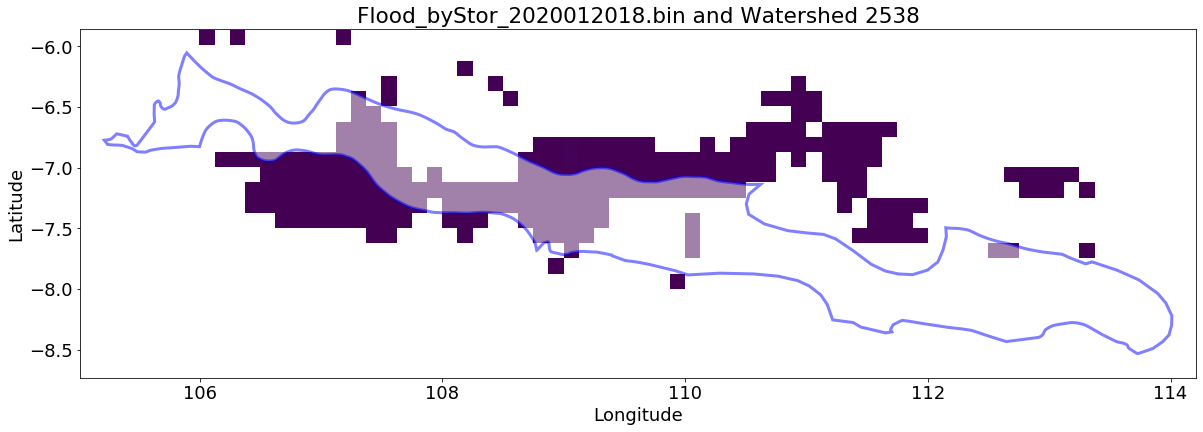

In [18]:
# plot polyon patch on image
poly=watersheds.loc[test_aqid,'geometry']
x1,y1,x2,y2 = watersheds.loc[[test_aqid],'geometry'].total_bounds
from matplotlib.patches import Polygon as mpl_Polygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
fig,ax= plt.subplots()
ax.imshow(vrt_data,extent=vrt_ext)
ax.add_patch(PolygonPatch(poly, fc='White',ec='Blue',alpha=0.5,linewidth=3))
ax.set_xlim(x1-0.2,x2+0.2)
ax.set_ylim(y1-0.2,y2+0.2)
ax.set(xlabel='Longitude',ylabel='Latitude',title = latest_data + " and Watershed " + str(test_aqid))
plt.show()

In [57]:
import json
# convert geometry into geojson format
test_json = json.loads(geopandas.GeoSeries([watersheds.loc[test_aqid,'geometry']]).to_json())
print(test_json)

In [26]:
import rasterio
from rasterio.mask import mask

In [66]:
with rasterio.open(vrt_file) as src:
     out_image, out_transform = mask(src, [test_json['features'][0]['geometry']], crop=True)

In [75]:
# extract data
no_data = src.nodata
# extract the values of the masked array
data = out_image[0]
# extract the row, columns of the valid values
row, col = np.where(data != no_data) 
point_value = np.extract(data != no_data, data)

In [109]:
from rasterio import Affine # or from affine import Affine
T1 = out_transform * Affine.translation(0.5, 0.5) # reference the pixel centre
rc2xy = lambda r, c: (c, r) * T1  
pixel_area_km2 = lambda lon, lat: 111.111*111.111*math.cos(lat*0.01745)*0.125*0.125 

In [110]:
d = geopandas.GeoDataFrame({'col':col,'row':row,'intensity':point_value})
# coordinate transformation
d['lon'] = d.apply(lambda row: rc2xy(row.row,row.col)[0], axis=1)
d['lat'] = d.apply(lambda row: rc2xy(row.row,row.col)[1], axis=1)
d['area'] = d.apply(lambda row: pixel_area_km2(row.lon,row.lat), axis=1)
# geometry
from shapely.geometry import Point
d['geometry'] =d.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
# first 2 points
d

/Users/JunWang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  This is separate from the ipykernel package so we can avoid doing imports until


,col,row,intensity,lon,lat,area,geometry
0,17,3,3.117416,107.3125,-6.4375,191.685019,POINT (107.31250 -6.43750)
1,17,4,3.145790,107.3125,-6.5625,191.637396,POINT (107.31250 -6.56250)
2,18,4,0.681340,107.4375,-6.5625,191.637396,POINT (107.43750 -6.56250)
3,16,5,0.172151,107.1875,-6.6875,191.588861,POINT (107.18750 -6.68750)
4,17,5,9.764755,107.3125,-6.6875,191.588861,POINT (107.31250 -6.68750)
...,...,...,...,...,...,...,...
74,39,12,0.177248,110.0625,-7.5625,191.223608,POINT (110.06250 -7.56250)
75,31,13,0.522171,109.0625,-7.6875,191.167788,POINT (109.06250 -7.68750)
76,39,13,0.295120,110.0625,-7.6875,191.167788,POINT (110.06250 -7.68750)
77,59,13,0.015111,112.5625,-7.6875,191.167788,POINT (112.56250 -7.68750)


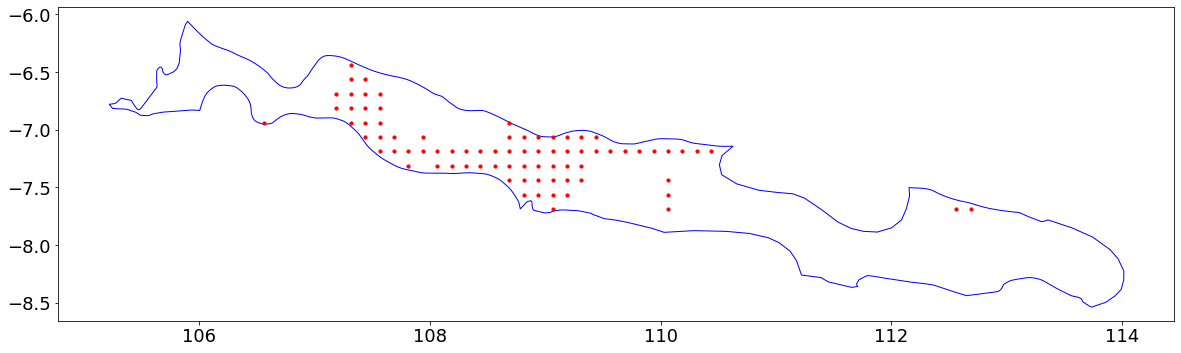

In [111]:
base = watersheds.loc[[test_aqid]].plot(color='white', edgecolor='blue')
d.plot(ax=base, marker='o', color='red', markersize=10)

In [128]:
#Summary part
#GFMS_TotalArea_km	GFMS_%Area	GFMS_MeanDepth	GFMS_MaxDepth	GFMS_Duration
print('Summary')
print('Watershed: ', test_aqid)
print("GFMS data: ", latest_data)
print("Number of data point: ", len(d))
print("GFMS_TotalArea_km2: ",d['area'].sum())
print("GFMS_%Area (%): ",d['area'].sum()/watersheds.loc[test_aqid]['SUM_area_km2']*100)
print("GFMS_MeanDepth (mm): ",d['intensity'].mean())
print("GFMS_MaxDepth (mm): ",d['intensity'].max())

Summary
Watershed:  2538
GFMS data:  Flood_byStor_2020012018.bin
Number of data point:  79
GFMS_TotalArea_km2:  15119.717543182656
GFMS_%Area (%):  24.91930276770253
GFMS_MeanDepth (mm):  3.290895938873291
GFMS_MaxDepth (mm):  52.98408508300781
